<a href="https://colab.research.google.com/github/javierzarateutec/utec-ml-proyecto3/blob/main/Proyecto3_Grupo3_(n_iteraciones).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Descarga de fuente de datos

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("veeralakrishna/butterfly-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/butterfly-dataset


## Importar librerías

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os, math, random, numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from itertools import product
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    f1_score,
    classification_report,
    confusion_matrix
)
import copy, itertools, numpy as np, torch
from collections import OrderedDict

## Parámetros

In [ ]:
DATA_DIR = path + "/leedsbutterfly/images"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)
labels = set(int(fname[:3]) for fname in os.listdir(DATA_DIR) if fname.lower().endswith(('.png','.jpg','.jpeg')))
NUM_CLASSES = len(labels)
print(labels)
print(NUM_CLASSES)

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10}
10


## Train, test, validation

In [ ]:
class ButterflyDataset(Dataset):
    def __init__(self, img_dir):
        self.img_dir = img_dir
        exts = (".png", ".jpg", ".jpeg", ".bmp", ".webp", ".tif", ".tiff")
        self.files = sorted([f for f in os.listdir(img_dir) if f.lower().endswith(exts)])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]
        fpath = os.path.join(self.img_dir, fname)
        image = Image.open(fpath)
        label = int(fname[:3]) - 1
        return image, label

In [ ]:
# Dataset completo
dataset = ButterflyDataset(DATA_DIR)
print("Total imágenes:", len(dataset))

Total imágenes: 832


Etiqueta: 0


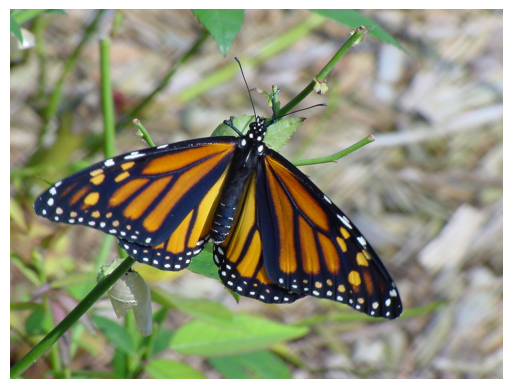

In [ ]:
# Obtener un ejemplo (índice 0)
img, label = dataset[0]

print("Etiqueta:", label)
plt.imshow(img)
plt.axis("off")
plt.show()

In [ ]:
# Split 80/10/10 (reproducible)
n = len(dataset)
n_train = int(0.8 * n)
n_val   = int(0.1 * n)
n_test  = n - n_train - n_val
print(n_train, n_val, n_test, n_train+n_val+n_test)

665 83 84 832


In [ ]:
generator = torch.Generator().manual_seed(42)
train_ds, val_ds, test_ds = random_split(dataset, [n_train, n_val, n_test], generator=generator)

## Pre procesamiento

In [ ]:
class TransformWrapper(Dataset):
    def __init__(self, base, transform):
        self.base = base
        self.transform = transform
    def __len__(self):
        return len(self.base)
    def __getitem__(self, idx):
        img, y = self.base[idx]
        img = img.convert("RGB")
        x = self.transform(img)
        return x, y

In [ ]:
IMAGE_SIZE = 128
BATCH_SIZE = 64

_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Lambda(lambda t: t.view(-1))  # volver 1 vector
])

train_ds = TransformWrapper(train_ds, _transform)
val_ds   = TransformWrapper(val_ds, _transform)
test_ds  = TransformWrapper(test_ds, _transform)


train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

input_dim = 3 * IMAGE_SIZE * IMAGE_SIZE  # por el flatten

## Configurar MLP

In [ ]:
def get_activation(name: str):
    name = name.lower()
    if name == "relu":    return nn.ReLU()
    if name == "tanh":    return nn.Tanh()
    if name == "sigmoid": return nn.Sigmoid()
    raise ValueError("activation must be one of: relu | tanh | sigmoid")

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_layers, num_classes, activation="relu"):
        super().__init__()
        act = get_activation(activation)
        layers = []
        prev = input_dim
        for h in hidden_layers:
            layers += [nn.Linear(prev, h), act]
            prev = h
        layers += [nn.Linear(prev, num_classes)]  # logits para CrossEntropy
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


## Función de pérdida y optimizador

In [ ]:
def make_optimizer(name, params, lr=1e-3, weight_decay=0.0, momentum=0.9):
    name = name.lower()
    if name == "adam":
        return torch.optim.Adam(params, lr=lr, weight_decay=weight_decay)
    elif name == "sgd":
        return torch.optim.SGD(params, lr=lr, momentum=momentum, weight_decay=weight_decay, nesterov=True)
    else:
        raise ValueError("optimizer must be 'adam' or 'sgd'")

## Evaluacion

In [ ]:
@torch.no_grad()
def evaluate(loader, model):
    model.eval()
    y_true, y_pred, losses = [], [], []
    for x, y in loader:
        x, y = x.to(DEVICE, non_blocking=True), torch.tensor(y).to(DEVICE, non_blocking=True)
        logits = model(x)
        loss = criterion(logits, y)
        losses.append(loss.item())
        preds = logits.argmax(dim=1)
        y_true.extend(y.cpu().numpy().tolist())
        y_pred.extend(preds.cpu().numpy().tolist())

    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="macro", zero_division=0)
    cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))
    return {
        "loss": float(np.mean(losses)),
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "cm": cm
    }

In [ ]:
@torch.no_grad()
def evaluate(loader, model, class_names=None, return_report=True):
    model.eval()
    y_true, y_pred, losses = [], [], []

    for x, y in loader:
        x, y = x.to(DEVICE, non_blocking=True), torch.tensor(y).to(DEVICE, non_blocking=True)
        logits = model(x)
        loss = criterion(logits, y)
        losses.append(loss.item())

        preds = logits.argmax(dim=1)
        y_true.extend(y.cpu().numpy().tolist())
        y_pred.extend(preds.cpu().numpy().tolist())

    # --- métricas ---
    acc = accuracy_score(y_true, y_pred)

    # Mantén tus métricas base como MACRO (compatibilidad)
    prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )

    # Nuevas: weighted
    prec_weighted, rec_weighted, f1_weighted, _ = precision_recall_fscore_support(
        y_true, y_pred, average="weighted", zero_division=0
    )

    cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))

    out = {
        "loss": float(np.mean(losses)),
        "accuracy": acc,
        # Alias (macro) para no romper prints existentes
        "precision": prec_macro,
        "recall": rec_macro,
        "f1": f1_macro,
        # También explícitas
        "precision_macro": prec_macro,
        "recall_macro": rec_macro,
        "f1_macro": f1_macro,
        "precision_weighted": prec_weighted,
        "recall_weighted": rec_weighted,
        "f1_weighted": f1_weighted,
        "cm": cm
    }

    if return_report:
        out["report"] = classification_report(
            y_true, y_pred,
            target_names=class_names if class_names is not None else None,
            digits=4, zero_division=0
        )

    return out


In [ ]:
def train_one_epoch(loader, model, optimizer):
    model.train()
    total_loss = 0.0
    for x, y in loader:
        x, y = x.to(DEVICE, non_blocking=True), torch.tensor(y).to(DEVICE, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
    return total_loss / len(loader.dataset)

## Iteración

In [ ]:
def run_experiment(cfg, train_loader, val_loader, input_dim, num_classes, epochs=15, seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)

    # Modelo fresco por config
    model = MLP(input_dim, cfg["hidden_layers"], num_classes, activation=cfg["activation"]).to(DEVICE)

    criterion = nn.CrossEntropyLoss()
    optimizer = make_optimizer(cfg["optimizer"], model.parameters(),
                               lr=cfg["lr"],
                               weight_decay=cfg.get("weight_decay", 0.0),
                               momentum=cfg.get("momentum", 0.9))

    history = {
        "train_loss": [],
        "train_acc": [],
        "train_prec": [],
        "train_rec": [],
        "train_f1": [],
        "val_loss": [],
        "val_acc": [],
        "val_prec": [],
        "val_rec": [],
        "val_f1": []
    }
    best_val_f1 = -1.0
    best_state = None

    for epoch in range(1, epochs+1):
        train_loss = train_one_epoch(train_loader, model, optimizer)
        train_metrics = evaluate(train_loader, model)
        val_metrics = evaluate(val_loader, model)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_metrics["accuracy"])
        history["train_prec"].append(train_metrics["precision"])
        history["train_rec"].append(train_metrics["recall"])
        history["train_f1"].append(train_metrics["f1"])

        history["val_loss"].append(val_metrics["loss"])
        history["val_acc"].append(val_metrics["accuracy"])
        history["val_prec"].append(val_metrics["precision"])
        history["val_rec"].append(val_metrics["recall"])
        history["val_f1"].append(val_metrics["f1"])

        if val_metrics["f1"] > best_val_f1:
            best_val_f1 = val_metrics["f1"]
            best_state = copy.deepcopy(model.state_dict())

    # Devolver resumen + estado del mejor
    out = {
        "config": cfg,
        "best_val_f1": best_val_f1,
        "last_val_loss": history["val_loss"][-1],
        "last_val_acc": history["val_acc"][-1],
        "history": history,
        "best_state": best_state
    }
    return out

In [ ]:
def iter_configs(space):
    keys = list(space.keys())
    vals = [space[k] for k in keys]
    for combo in itertools.product(*vals):
        cfg = dict(zip(keys, combo))
        yield cfg


In [ ]:
space = OrderedDict({
    "hidden_layers": [
        [512, 256, 128],
        [512, 256],
        #[256, 128]
    ],
    "activation": ["relu", "tanh", "sigmoid"],     # puedes incluir | ,
    "optimizer": ["adam", "sgd"],
    "lr": [5e-4],
    "weight_decay": [1e-4],
    "momentum": [0.9] #     # momentum solo aplica si optimizer="sgd"; se ignora para adam
})


In [ ]:
combinations = []

for hl, act, opt, lr, wd in product(
    space["hidden_layers"],
    space["activation"],
    space["optimizer"],
    space["lr"],
    space["weight_decay"]
):
    if opt == "sgd":
        for m in space["momentum"]:
            combinations.append((hl, act, opt, lr, wd, m))
    else:
        combinations.append((hl, act, opt, lr, wd))

print("Total combinaciones:", len(combinations))

Total combinaciones: 12


In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
results = []
MAX_TRIALS = 20  # por si quieres cortar temprano; o usa None para todas las combinaciones
for i, cfg in enumerate(iter_configs(space), start=1):
    if MAX_TRIALS and i > MAX_TRIALS:
        break
    print(f"\n=== Trial {i} ===")
    print(cfg)
    res = run_experiment(cfg, train_loader, val_loader, input_dim, NUM_CLASSES, epochs=15, seed=42)
    print(f"val_f1={res['best_val_f1']:.4f}, val_acc={res['last_val_acc']:.4f}")
    results.append(res)


=== Trial 1 ===
{'hidden_layers': [512, 256, 128], 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.0005, 'weight_decay': 0.0001, 'momentum': 0.9}
val_f1=0.4225, val_acc=0.4578

=== Trial 2 ===
{'hidden_layers': [512, 256, 128], 'activation': 'relu', 'optimizer': 'sgd', 'lr': 0.0005, 'weight_decay': 0.0001, 'momentum': 0.9}
val_f1=0.0988, val_acc=0.1205

=== Trial 3 ===
{'hidden_layers': [512, 256, 128], 'activation': 'tanh', 'optimizer': 'adam', 'lr': 0.0005, 'weight_decay': 0.0001, 'momentum': 0.9}
val_f1=0.2352, val_acc=0.1566

=== Trial 4 ===
{'hidden_layers': [512, 256, 128], 'activation': 'tanh', 'optimizer': 'sgd', 'lr': 0.0005, 'weight_decay': 0.0001, 'momentum': 0.9}
val_f1=0.2421, val_acc=0.3133

=== Trial 5 ===
{'hidden_layers': [512, 256, 128], 'activation': 'sigmoid', 'optimizer': 'adam', 'lr': 0.0005, 'weight_decay': 0.0001, 'momentum': 0.9}


In [ ]:
# 1) Graficar train vs val para varias métricas
def plot_history(history, metrics=("loss","acc","prec","rec","f1"), start_epoch=1, show=True):
    # Intento robusto de inferir n_epochs
    any_key = next((k for k,v in history.items() if isinstance(v, (list, tuple)) and len(v)>0), None)
    n_epochs = len(history.get("val_loss", history.get(any_key, [])))
    epochs = np.arange(start_epoch, start_epoch + n_epochs)

    cfg = {
        "loss": ("train_loss","val_loss","Loss (train vs val)","Loss"),
        "acc":  ("train_acc","val_acc","Accuracy (train vs val)","Accuracy"),
        "prec": ("train_prec","val_prec","Precision (train vs val)","Precision"),
        "rec":  ("train_rec","val_rec","Recall (train vs val)","Recall"),
        "f1":   ("train_f1","val_f1","F1-score (train vs val)","F1-score"),
    }
    for m in metrics:
        if m not in cfg:
            continue
        k_tr, k_val, title, ylabel = cfg[m]
        if k_tr in history and k_val in history:
            plt.figure(figsize=(6,4))
            plt.plot(epochs, history[k_tr], label=k_tr)
            plt.plot(epochs, history[k_val], label=k_val)
            plt.xlabel("Epoch")
            plt.ylabel(ylabel)
            plt.title(title)
            plt.legend()
            plt.grid(True)
            if show:
                plt.show()

In [ ]:
# ---------- 4) Ordenar y mostrar Top-N ----------
results_sorted = sorted(results, key=lambda r: r["best_val_f1"], reverse=True)
TOP_N = min(5, len(results_sorted))
print("\nTop resultados por F1 (validación):")
for rank, r in enumerate(results_sorted[:TOP_N], start=1):
    cfg = r["config"]
    print(f"{rank:02d}) F1={r['best_val_f1']:.4f} | Acc={r['last_val_acc']:.4f} | "
          f"HL={cfg['hidden_layers']} | act={cfg['activation']} | opt={cfg['optimizer']} | "
          f"lr={cfg['lr']} | wd={cfg['weight_decay']}")

best = results_sorted[0]
best_cfg = best["config"]
print("\nMejor configuración:", best_cfg)

In [ ]:
plot_history(results_sorted[0]["history"], metrics=("loss","acc","f1"))

In [ ]:
import pandas as pd

In [ ]:
df_resultados = pd.DataFrame(results_sorted)

In [ ]:
df_resultados

In [ ]:
best_cfg

In [ ]:
best_model = MLP(input_dim, best_cfg["hidden_layers"], NUM_CLASSES, activation=best_cfg["activation"]).to(DEVICE)
best_model.load_state_dict(best["best_state"])


test_metrics = evaluate(test_loader, best_model, class_names=None, return_report=True)

print("\n== Test Metrics ==")

print("\nConfusion Matrix (test):\n", test_metrics["cm"])

print("\n== Classification Report ==")
print(test_metrics["report"])